In [1]:
%matplotlib inline
import sys
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import math
#import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
from numpy.random import choice
import itertools
from sklearn import manifold
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
from scipy.stats import norm
import re
from scipy import stats
from scipy.spatial import Voronoi
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(d)
    sys.stdout.flush()

def DiffusionWeightAverage(threshold,data):#[value,samplesize] in data
    smoothData=[data[0]]
    for n,j in enumerate(data[1:]):
        value,sampleSize=j
        if sampleSize<threshold:
            lastValue,lastSampleSize=smoothData[n-1]
            value=np.average([lastValue,value], weights=[lastSampleSize, sampleSize])
        smoothData.append([value,sampleSize])
    return smoothData

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant,beta] 

def clean(s): return re.sub('[^A-Za-z0-9]+', ' ', s).strip().lower()


/Users/chengjun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# baidu 150 book edges

In [41]:
import pandas as pd
book_df = pd.read_csv('bjmobile_app_network.txt')
book_df['node1'] = book_df['node1'].astype(str)
book_df['node2'] = book_df['node2'].astype(str)

book_df[:3]

,node1,node2,app_obs
0,QQ,掌上百度,3112
1,QQLive,掌上百度,2604
2,优酷视频,掌上百度,755


In [29]:
cat_df = pd.read_csv('bjmobile_app_info.csv')
cat_df[:3]

,node,category
0,掌上百度,搜索
1,QQ,社交沟通
2,QQLive,视频


In [42]:
book_df['app_obs'][:3]

0    3112
1    2604
2     755
Name: app_obs, dtype: int64

In [43]:
len(book_df)

17874

In [44]:
sorted(['g4459599bc8d376eeaeaa31d7','f327d079de80d4d8d15a4ff7'])

['f327d079de80d4d8d15a4ff7', 'g4459599bc8d376eeaeaa31d7']

In [45]:
G=nx.Graph()
for i in book_df.index:
    G.add_edge(book_df.node1[i],book_df.node2[i], weight=book_df.app_obs[i])

In [46]:
# S={}
# with open('/Users/lingfeiw/Documents/research/KatyPNAS/katySkills.txt','rb') as f:
#     for line in f:
#         line=line.strip().split('\t')
#         s=line[1].strip().split('"')[1]
#         S[int(line[0])]=s.lower()
# RS=dict((v,k) for k,v in S.items())

From=[]
To=[]
for ii in book_df.index:
    i,j,w= book_df.node1[ii],book_df.node2[ii], book_df.app_obs[ii]
    a, b = sorted([str(i), str(j)])
    x,y=zip(*[[a,b]]*w)
    From+=x
    To+=y



len(From),len(To)

(741469, 741469)

In [49]:
len(G.nodes())

244

In [47]:
sorted([[G.degree()[i],i] for i in G.nodes()],reverse=True)[:10]

[[243, '手机腾讯网'],
 [243, '微信'],
 [243, 'QQ'],
 [242, '掌上百度'],
 [241, 'QVOD快播'],
 [240, '淘宝网'],
 [240, 'QQLive'],
 [239, '百度地图'],
 [239, '新浪微博'],
 [239, '应用宝']]

In [48]:
sorted([[G.degree()[i],i] for i in G.nodes()],reverse=True)[-10:]

[[31, '手机乐园市场'],
 [30, '红袖添香'],
 [30, '365搜房'],
 [29, '超级火车票'],
 [26, '东方航空'],
 [23, '新浪UC语音'],
 [22, '饭否'],
 [20, '纽约时报'],
 [13, '电驴大全'],
 [12, '亿部书城']]

## Network Randomization

In [50]:
D=defaultdict(lambda:0)
for x,y in zip(From,To):
    D[(x,y)]+=1
D=dict(D)

DD=defaultdict(lambda:[])
for i in range(100):
    flushPrint(str(i))
    D1=defaultdict(lambda:0)
    To1=np.random.permutation(To)
    for x,y in zip(From,To1):
        D1[(x,y)]+=1
    for x,y in D1:
        DD[(x,y)].append(D1[(x,y)])
DD=dict(DD)

99

In [51]:
list(DD.keys())[:3]

[('QQ', '迷你地图'), ('QQ', '京东商城'), ('QQ', '美图秀秀')]

In [52]:
list(D.keys())[:3]

[('QQ', '掌上百度'), ('QQLive', '掌上百度'), ('优酷视频', '掌上百度')]

In [53]:
d=[]
for x,y in D:
    if (x,y) in DD:
        m=np.mean(DD[(x,y)]) 
        sd=np.std(DD[(x,y)])
        if sd==0:
            sd=1
        w=D[(x,y)]
        z1=w-m
        z=(w-m+0.0)/sd
        d.append([G.degree()[x],G.degree()[y], m, sd, w, z1, z ])
ki,kj,m,sd,w,z1,z=np.array(d).T

In [54]:
max(z),min(z)

(147.69148404155493, -21.104090192562257)

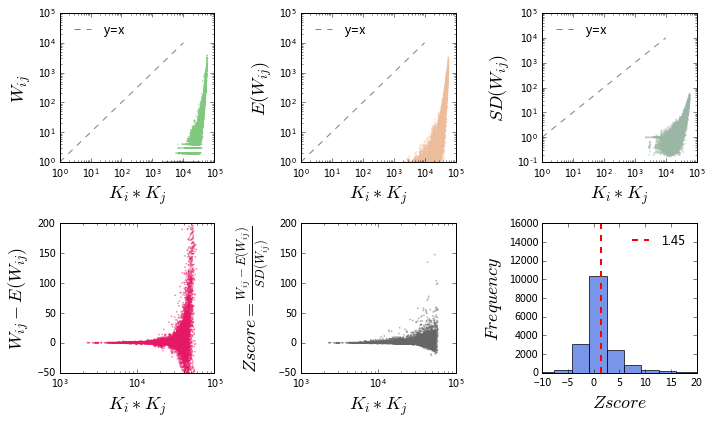

In [55]:
fig = plt.figure(figsize=(10, 6),facecolor='white')
cmap = cm.get_cmap('Accent',5)
ax = fig.add_subplot(231)
plt.scatter(ki*kj,w,facecolor=cmap(0),edgecolor='none',s=3,alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10000],[1,10000],linestyle='--',color='gray',label='y=x')
plt.legend(loc=2,frameon=False)
plt.xlabel(r'$K_i*K_j$',size=18)
plt.ylabel(r'$W_{ij}$',size=18)
plt.ylim(1,10**5)

ax = fig.add_subplot(232)
plt.scatter(ki*kj,m,facecolor=cmap(1),edgecolor='none',s=3,alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10000],[1,10000],linestyle='--',color='gray',label='y=x')
plt.legend(loc=2,frameon=False)
plt.xlabel(r'$K_i*K_j$',size=18)
plt.ylabel(r'$E(W_{ij})$',size=18)
plt.ylim(1,10**5)

ax = fig.add_subplot(233)
plt.scatter(ki*kj,sd,facecolor=cmap(2),edgecolor='none',s=3,alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10000],[1,10000],linestyle='--',color='gray',label='y=x')
plt.legend(loc=2,frameon=False)
plt.xlabel(r'$K_i*K_j$',size=18)
plt.ylabel(r'$SD(W_{ij})$',size=18)
plt.ylim(0.1,10**5)

ax = fig.add_subplot(234)
plt.scatter(ki*kj,z1,facecolor=cmap(3),edgecolor='none',s=3,alpha=0.5)
plt.xscale('log')
#plt.yscale('log')
#plt.plot([1,10000],[1,10000],linestyle='--',color='gray',label='y=x')
#plt.legend(loc=2,frameon=False)
plt.xlabel(r'$K_i*K_j$',size=18)
plt.ylabel(r'$W_{ij} - E(W_{ij})$',size=18)
plt.ylim(-50,200)

ax = fig.add_subplot(235)
plt.scatter(ki*kj,z,facecolor=cmap(4),edgecolor='none',s=3,alpha=0.5)
plt.xscale('log')
#plt.yscale('log')
#plt.plot([1,10000],[1,10000],linestyle='--',color='gray',label='y=x')
#plt.legend(loc=2,frameon=False)
plt.xlabel(r'$K_i*K_j$',size=18)
plt.ylabel(r'$Zscore = \frac{W_{ij} - E(W_{ij})}{SD(W_{ij})}$',size=18)
plt.ylim(-50,200)

ax = fig.add_subplot(236)
mz=np.mean(z)
plt.plot([mz,mz],[0,16000],'r-',linewidth=2,linestyle='--',label=str(np.round(mz,2)))
plt.hist(z,50,color='RoyalBlue',alpha=0.7)
plt.xlim(-10,20)
plt.legend(loc=1,frameon=False)
plt.ylabel(r'$Frequency$',size=18)
plt.xlabel(r'$Zscore $',size=18)

plt.tight_layout()
#plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/KatyskillDepopularize.png')
#plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/KatyskillDepopularize.pdf')

In [56]:
Z=defaultdict(lambda:defaultdict(lambda:0))
for x,y in D:
    if (x,y) in DD:
        m=np.mean(DD[(x,y)]) 
        sd=np.std(DD[(x,y)])
        w=D[(x,y)]
        if sd==0:
            sd=1
        z=(w-m+0.0)/sd
        Z[x][y]=z
        Z[y][x]=z
Z=dict(Z)

In [57]:
np.percentile(z,80)

-1.1858861809057648

In [58]:
list(Z)[:3]

['QQ', '掌上百度', 'QQLive']

In [59]:
'''
GZ=nx.Graph()
theta=1.5
for i in Z:
    si=S[i]
    forward=[S[a] for a,b in Z[i].items() if b>theta]
    for j in forward:
        GZ.add_edge(si,j)
'''
GZ=nx.Graph()
for i in Z:
    top3Zscore=[a for a,b in sorted(list(Z[i].items()),key=lambda x:-x[1])][:4]
    for j in top3Zscore:
        GZ.add_edge(i,j)

In [60]:
nx.number_connected_components(GZ)

1

In [61]:
G3=nx.Graph()
for i in G.nodes().keys():
    for j,w in sorted(G[i].items(),key=lambda x:-x[1]['weight'])[:1]:
        G3.add_edge(i,j,weight=w['weight'])

In [62]:
nx.number_connected_components(GZ),nx.number_connected_components(G3)

(1, 1)

In [64]:
p=nx.shortest_path_length(GZ)
nodes = GZ.nodes().keys()


In [65]:
# calculate the network distance

from sklearn.manifold import TSNE
from sklearn.manifold import MDS

def ISOMAP(graph,method):
    dists = []
    p=nx.shortest_path_length(graph)
    #p=nx.all_pairs_dijkstra_path_length(G3)
    n=0
    nodes=graph.nodes().keys()
    for i in p:
        n+=1
        if n%100==0:
            flushPrint(str(n/100))#88
        try:
            vs=[i[1][j] for j in nodes]
        except:
            pass
        dists.append(vs)
    adist = np.array([np.array(i) for i in dists])
    amax = np.array([np.float(np.max(i)) for i in adist])
    amax = adist/amax
    if method=='MDS':
        coords= MDS(n_components=2, dissimilarity="precomputed", random_state=6).fit_transform(adist)    
    if method=='TSNE':
        coords = TSNE(n_components=2,metric="precomputed").fit_transform(adist)
    dic=dict((i,j) for i,j in zip(nodes,coords))  
    return dic

In [103]:
from sklearn.cluster import KMeans

dic=ISOMAP(GZ,'TSNE')

2.0

In [104]:
X=np.array(list(dic.values()) )
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
group=dict(zip(dic.keys(),kmeans.labels_))

In [105]:
x,y=np.array(list(dic.values())).T
sizes=[G.degree()[i] for i in GZ.nodes().keys()]
gs=[group[i] for i in GZ.nodes().keys()]


In [106]:
gs[:3]

[1, 1, 1]

In [107]:
with open('bjmobile_PosBG.txt', "w") as f:
    for i in dic:
        k=G.degree()[i]
        x,y=dic[i]
        g=group[i]
        f.write(i+'\t'+ str(x)+ '\t'+ str(y)+ '\t'+ str(k)+'\t'+ str(g) + '\n')

In [108]:
nodename = list(GZ.nodes().keys())

In [109]:
bookname = pd.read_csv('bjmobile_app_info.csv')
bookname['node'] = bookname['node'].astype('str')
bookname['category'] = bookname['category'].astype('str')

bookname[:3]

,node,category
0,掌上百度,搜索
1,QQ,社交沟通
2,QQLive,视频


In [110]:
bookname = bookname[bookname.node.isin(nodename)  ]

len(bookname)

244

In [111]:
bookcat_dic ={bookname['node'][i]:  bookname['category'][i] for i in bookname.index} 

In [112]:
unique_cat = list(set(bookcat_dic.values()))
unique_cat_dic = {i:k for k, i in enumerate(unique_cat)}

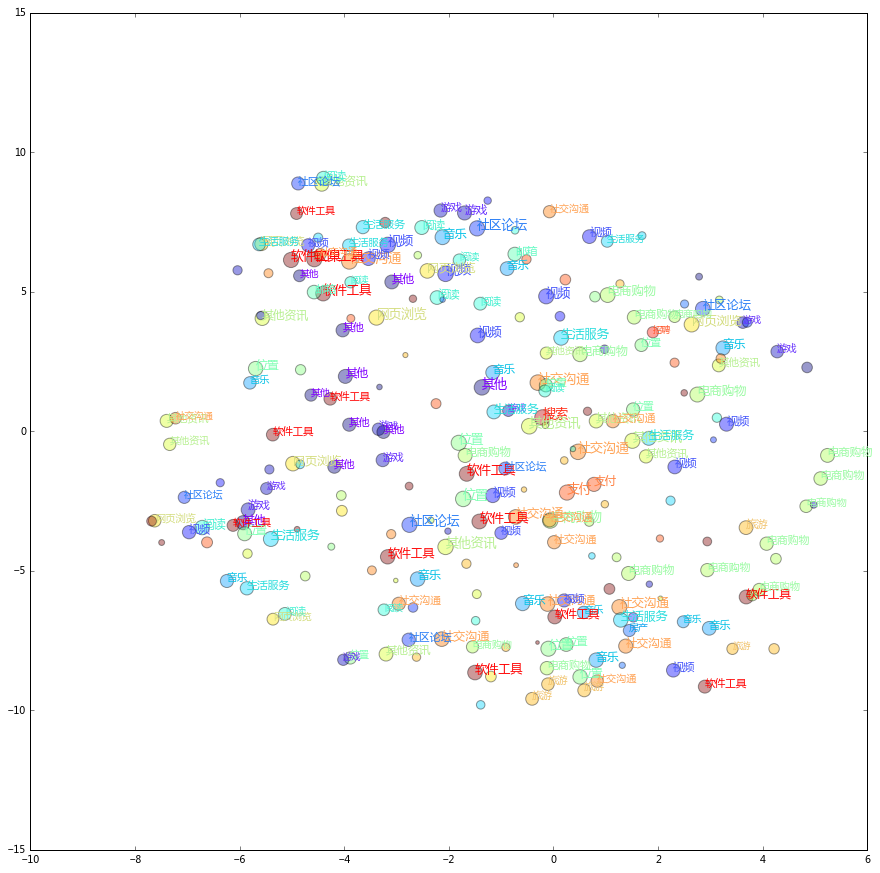

In [113]:
fig = plt.figure(figsize = (15, 15))
cmap = cm.get_cmap('rainbow',len(unique_cat))
x,y=np.array(list(dic.values())).T
sizes=[G.degree()[i] for i in GZ.nodes().keys()]
#gs=[group[i] for i in dic]
gs = [unique_cat_dic[bookcat_dic[i]] for i in dic]
plt.scatter(x, y, s = sizes, c=gs, alpha = .4)
for i in dic:
    k=G.degree()[i]
    if k>120:
        #if k>300:
        #    k=300
        x,y=dic[i]
        g=group[i]
        #plt.text(x,y,bookname_dic[i],fontsize=k/30.0+3,color=cmap(g))
        plt.text(x,y,bookcat_dic[i], fontsize=k/30.0+5, color = cmap(unique_cat_dic[bookcat_dic[i]])) #color=cmap(g))
#plt.savefig('bjmobile_isomap_cat.png')


# two graphs

In [114]:
P1={}
with open('bjmobile_PosBG.txt', "r") as f:
    for line in f:
        i,x,y,k,g=line.strip().split('\t')
        bookcat_dic[i]
        P1[i]=[float(x),float(y),int(k),unique_cat_dic[bookcat_dic[i]] ]
        #P1[i]=[float(x),float(y),int(k),int(g)]

In [115]:
list(P1.items())[:3]

[('QQ', [-3.9013677, 6.0891867, 243, 14]),
 ('360手机助手', [-5.0162253, 6.140965, 231, 18]),
 ('QQLive', [-3.1676486, 6.679981, 240, 2])]

In [116]:
nodeClusterLabel=dict((k,v[-1]) for k,v in P1.items())
pos=dict((k,v[:2]) for k,v in P1.items())
allPoints = pos.copy() #allPoints to include other types of points in future

# generate dots on the edge and merge into allpoints
r=3;N=1000;rs=[]
x,y=zip(*pos.values())
xmin,xmax=min(x),max(x)
ymin,ymax=min(y),max(y)
k=2
xmax+=k*r;ymax+=k*r;xmin-=k*r;ymin-=k*r
t=np.hstack([np.random.uniform(xmin,xmax,size=(N,1)),np.random.uniform(ymin,ymax,size=(N,1))])
mins=np.array([min([np.linalg.norm(i-j) for j in pos.values()]) for i in t])
t=t[mins>r]
surroundPoints=dict(('surroundXXX'+str(n),list(k)) for n,k in enumerate(t))

# genterate retangle-shape points around nodes
n=5
rectPoints={}
rectPointsCluster={}
m=0
for i in pos:
    x,y=pos[i]
    k=P1[i][2]
    l=k/50.0+0.02
    xs=np.random.uniform(x-l,x+l,n)
    ys=np.random.uniform(y-l,y+l,n)
    cos=list(zip(list(xs)+list(xs),[y-l]*n+[y+l]*n)) + list(zip([x-l]*n+[x+l]*n,list(ys)+list(ys)))
    for p in cos:
        rectPoints['rectXXX'+str(m)]=p
        rectPointsCluster['rectXXX'+str(m)]=nodeClusterLabel[i]
        m+=1

allPoints.update(surroundPoints)
#allPoints.update(rectPoints)
regions, vertices = voronoi_finite_polygons_2d(Voronoi(list(allPoints.values())))
Regions=dict(zip(allPoints.keys(),regions))
Vertices = dict(zip(range(len(vertices)),vertices))

In [117]:
len(list(nodeClusterLabel.items()))

244

In [118]:
list(rectPointsCluster.items())[:3]

[('rectXXX0', 14), ('rectXXX1', 14), ('rectXXX2', 14)]

In [119]:
cp = cm.get_cmap('rainbow_r', len(unique_cat_dic))
cp(0)

(1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0)

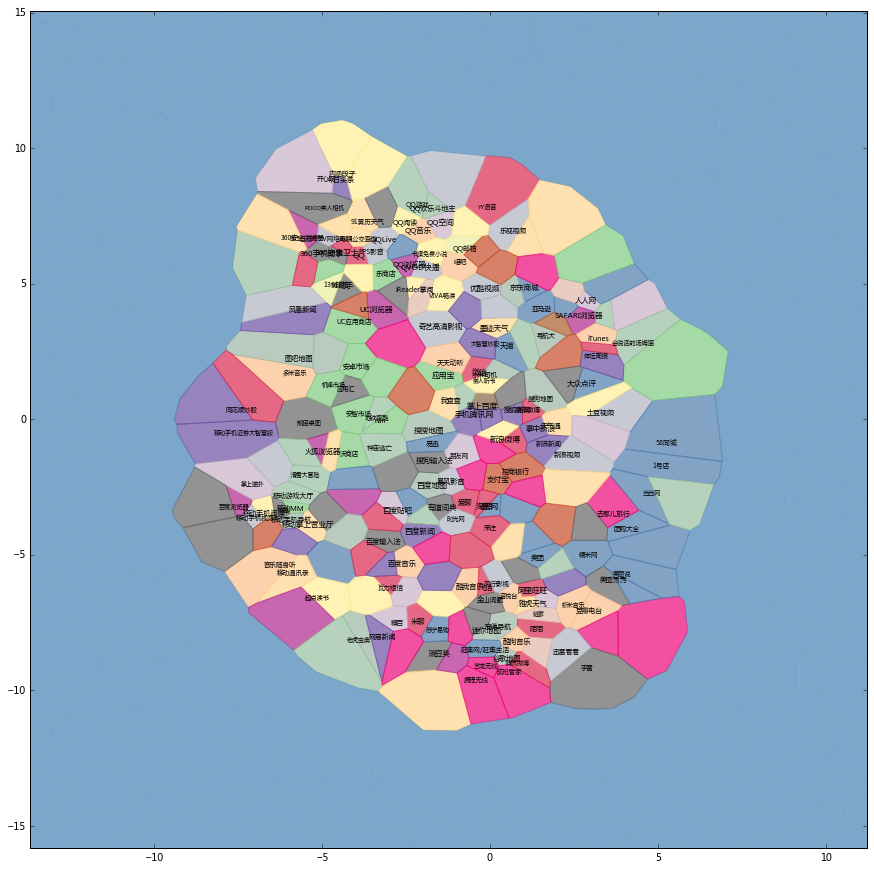

In [120]:
#cp={0:'#F5AFAD',1:'#F4CEA2',2:'#D7D6DB'}
import matplotlib.cm as cm
cp = cm.get_cmap('Accent', len(unique_cat_dic))

fig = plt.figure(figsize=(15, 15),facecolor='white')
ax = fig.add_subplot(111)
for j in pos:
    x,y=pos[j]
    k=P1[j][2]
    if k>140:
        plt.text(x,y,j,fontsize=k/50.0+3,va='center',ha='center')
        
for i in Regions:
    polygon = np.array([Vertices[j] for j in Regions[i]])
    if 'surroundXXX' in str(i):
        plt.fill(*zip(*polygon), alpha=0.7,facecolor='SteelBlue',edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor='SteelBlue',alpha=0.1)
    elif 'rectXXX' in str(i): 
        plt.fill(*zip(*polygon), alpha=0.7,facecolor=cp(unique_cat_dic[bookcat_dic[i]]),edgecolor='none') # cp[rectPointsCluster[i]],edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor=cp(unique_cat_dic[bookcat_dic[i]]),alpha=0.1)
    else:
        plt.fill(*zip(*polygon), alpha=0.7,color= cp(unique_cat_dic[bookcat_dic[i]]))#cp[nodeClusterLabel[i]])

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#plt.savefig('bjmobile_mds_map.png')
plt.savefig('bjmobile_map.png')
plt.show()

In [410]:
for index, (label, (x, y)) in enumerate(pos.items()):
    print(label, x, y)

4459599bc8d376eeaeaa31d7 9.058801 -1.5153334
43bd92e46c85ec3a86c2c570 -6.55157 -0.7560885
4fb2d64b3968011ca30091f8 -8.403808 -2.2296047
2ef958afd5bbfd0a795673a9 -6.6229434 0.11398876
201f197204a1b0717ed5dd85 -7.6062503 0.48315164
f327d079de80d4d8d15a4ff7 -0.20881219 -5.4023614
f9ad6b0b7e21af45b207a848 0.76194745 -5.242945
ed214dbb58f5f61fb636664d -1.1258786 -5.9555387
f79e553e767f5acfa1c7cdfc 0.28896093 -3.8120065
fef91361453610661fd9f42e 0.016930584 -4.3130445
6c1507d2f78a6529657d53c2 -8.618066 -3.6027923
67578e8eff00bed5b8f31d25 -9.014479 -3.2016318
350b66a3482fb4daa58d4bd7 -9.111845 -2.041397
fb99073c50e2524de4187e6b -6.526673 -5.17872
df707f5c192e45361066f5d3 -7.062181 -4.7121663
ac55534c81c758f5f71f6723 -6.856647 -4.2580895
df1635412af90242a895e580 -7.8319483 -4.726749
0d00d9532f60ddccda38a0c7 -0.059518084 7.4853616
0c306a5aeff9aef8941e0666 0.90392876 8.523911
0c3a04b731b765ce050814fc 0.98273563 6.519292
0d588b1a8e9951e79b892792 0.3598486 8.296859
2060f963680203d8cf2f2474 1.578670

In [416]:
nodeClusterLabel['0c306a5aeff9aef8941e0666']

11

In [121]:
from matplotlib.patches import FancyBboxPatch

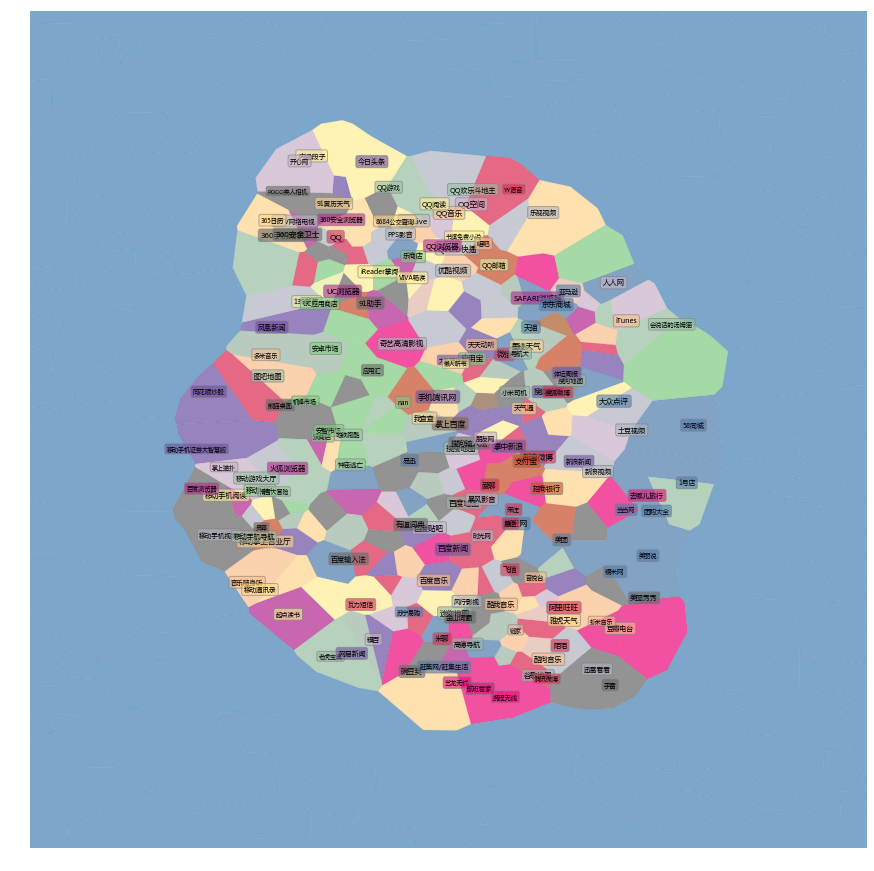

In [124]:
#cp={0:'#F5AFAD',1:'#F4CEA2',2:'#D7D6DB'}
cp = cm.get_cmap('Accent', len(unique_cat_dic))

fig = plt.figure(figsize=(15, 15),facecolor='white')
ax = fig.add_subplot(111)
#fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

delta=0.5
embedding = np.array(list(pos.values())).T
#embedding = embedding.tolist()
for index, (label, (x, y)) in enumerate(pos.items()):
    k=P1[label][2]
    if k>140:
        dx = x - list(embedding)[0]
        dy = y - list(embedding)[1]
        dx[index] = 1
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            ha = 'left'
            x = x + delta
        else:
            ha = 'right'
            x = x - delta
        if this_dy > 0:
            va = 'bottom'
            y = y + delta
        else:
            va = 'top'
            y = y - delta
        plt.text(x, y,label, size=k/50.0+3, ha=ha, va=va, 
                 bbox=dict(facecolor= cp(nodeClusterLabel[label]), # cp[nodeClusterLabel[label]], 
                           edgecolor='gray', alpha=.6,boxstyle='round,pad=0.3'))
        
for i in Regions:
    polygon = np.array([Vertices[j] for j in Regions[i]])
    if 'surroundXXX' in str(i):
        plt.fill(*zip(*polygon), alpha=0.7,facecolor='SteelBlue',edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor='SteelBlue',alpha=0.1)
    elif 'rectXXX' in str(i): 
        plt.fill(*zip(*polygon), alpha=0.7,facecolor=cp(unique_cat_dic[bookcat_dic[i]]),edgecolor='none') # cp[rectPointsCluster[i]],edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor=cp(unique_cat_dic[bookcat_dic[i]]),alpha=0.1)
    else:
        plt.fill(*zip(*polygon), alpha=0.7,facecolor=cp(unique_cat_dic[bookcat_dic[i]]), edgecolor = 'none')#cp[nodeClusterLabel[i]])
        plt.fill(*zip(*polygon), alpha=0.1,edgecolor= cp(unique_cat_dic[bookcat_dic[i]]), facecolor = 'none')#cp[nodeClusterLabel[i]])

        #plt.fill(*zip(*polygon), alpha=0.7,color= cp(unique_cat_dic[bookcat_dic[i]]))#cp[nodeClusterLabel[i]])
#         plt.fill(*zip(*polygon), alpha=0.7,facecolor=cp[rectPointsCluster[i]],edgecolor='none')
#         plt.fill(*zip(*polygon), facecolor='none',edgecolor=cp[rectPointsCluster[i]],alpha=0.3)
#     else:
#         plt.fill(*zip(*polygon), alpha=0.7,color=cp[nodeClusterLabel[i]])

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.axis('off')
plt.margins(0)
import matplotlib
plt.savefig('bjmobile_good_map.png', frameon = False, pad_inches = 0, bbox_inches = 'tight')
plt.show()

In [125]:
xmax-xmin, ymax-ymin

(24.920776500000002, 30.871712000000002)

In [126]:
xmin, ymin, xmax, ymax

(-13.681688000000001, -15.803943, 11.239088500000001, 15.067769)

In [127]:
def func(x, y):     return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

In [128]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [129]:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

In [130]:
from scipy.interpolate import griddata

In [131]:
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

/Users/chengjun/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:806: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


TypeError: You must first set_array for mappable

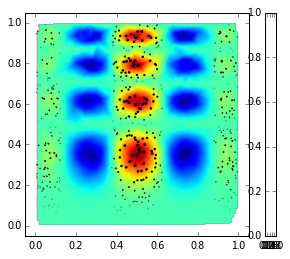

In [132]:
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.scatter(points[:,0], points[:,1], s=values*20)
plt.colorbar()

In [133]:
grid_x, grid_y = np.mgrid[-30:30:30j, -30:30:30j]
points=np.array(list(pos.values()))
mm=max([G.degree()[i] for i in pos])+0.0
values=np.array([G.degree()[i] for i in pos])/mm
grid_z1 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [134]:
len(grid_x), len(grid_y)

(30, 30)

In [135]:
len(values)

244

In [136]:
grid_z1.T[0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

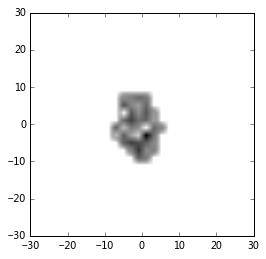

In [137]:
plt.imshow(grid_z1.T, extent=(-30,30,-30,30), origin='lower',alpha=1,cmap='gray')
#plt.scatter(points[:,0], points[:,1], s=values)

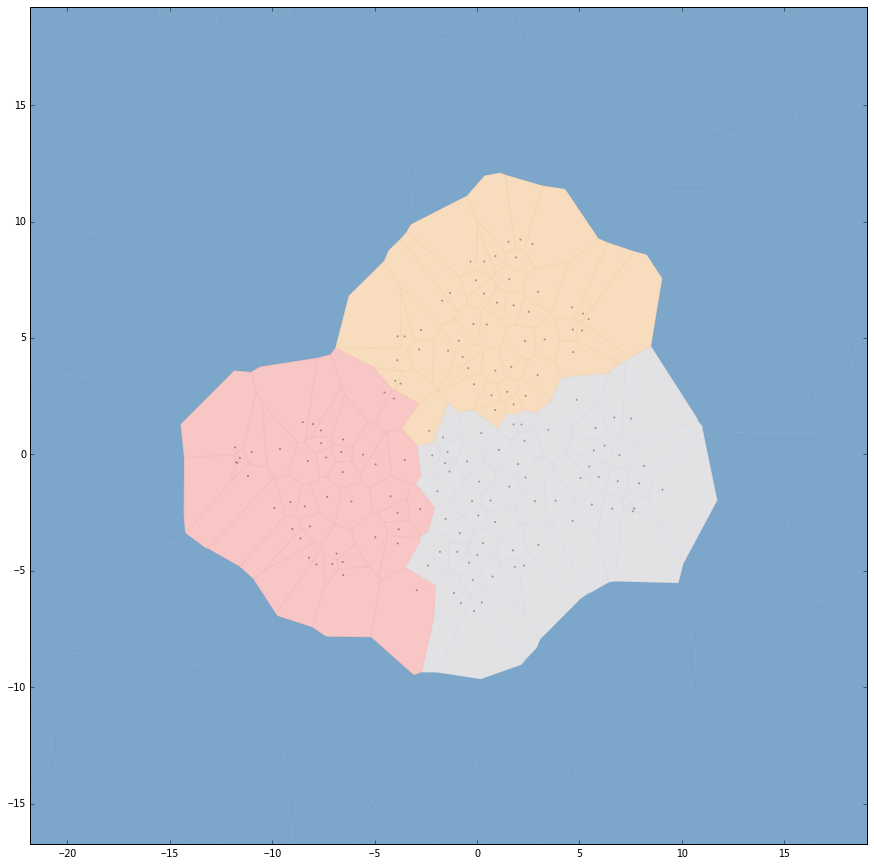

In [206]:
cp={0:'#F5AFAD',1:'#F4CEA2',2:'#D7D6DB'}
fig = plt.figure(figsize=(15, 15),facecolor='white')
ax = fig.add_subplot(111)

plt.scatter(points[:,0], points[:,1], s=values)

for i in Regions:
    polygon = np.array([Vertices[j] for j in Regions[i]])
    if 'surroundXXX' in str(i):
        plt.fill(*zip(*polygon), alpha=0.7,facecolor='SteelBlue',edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor='SteelBlue',alpha=0.1)
    elif 'rectXXX' in str(i): 
        plt.fill(*zip(*polygon), alpha=0.7,facecolor=cp[rectPointsCluster[i]],edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor=cp[rectPointsCluster[i]],alpha=0.3)
    else:
        plt.fill(*zip(*polygon), alpha=0.7,facecolor=cp[nodeClusterLabel[i]],edgecolor='none')
        plt.fill(*zip(*polygon), facecolor='none',edgecolor=cp[nodeClusterLabel[i]],alpha=0.3)

        
#plt.imshow(grid_z1.T, extent=(-30,30,-30,30), origin='lower',alpha=0.5,cmap='gray')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/figures/skills.png')
plt.show()

## heatmappy

In [138]:
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image,ImageOps,ImageFilter

# https://github.com/LumenResearch/heatmappy/blob/master/heatmappy/heatmap.py


https://github.com/LumenResearch/heatmappy/blob/master/heatmappy/heatmap.py


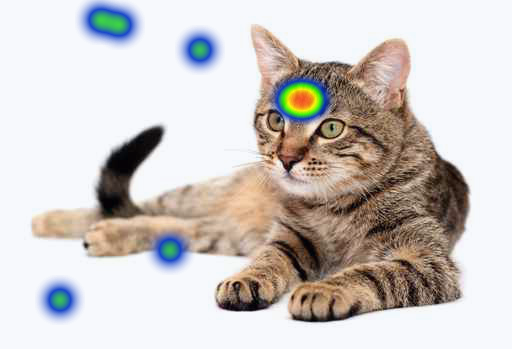

In [139]:
def _img_to_opacity(img, opacity):
    img = img.copy()
    alpha = img.split()[3]
    alpha = alpha.point(lambda p: int(p * opacity))
    img.putalpha(alpha)
    return img

def heatmappy(image,opacity,point_diameter,point_strength,points):
    width, height=image.size
    dot = (Image.open('./img/450pxdot.png').copy()
                        .resize((point_diameter, point_diameter), resample=Image.ANTIALIAS))
    dot = _img_to_opacity(dot, point_strength)
    heat = Image.new('L', (width, height), color=255)
    for x, y in points:
        x, y = int(x - point_diameter/2), int(y - point_diameter/2)
        heat.paste(dot, (x, y), dot)
    img = Image.open('./img/default.png')
    img = img.resize((256, img.height))
    colours = (img.getpixel((x, 0)) for x in range(256))
    colours = [(r/255.0, g/255.0, b/255.0, a/255.0) for (r, g, b, a) in colours]
    _cmap= LinearSegmentedColormap.from_list('from_image', colours)
    arr = np.array(heat)
    rgba_img = _cmap(arr, bytes=True)
    heat=Image.fromarray(rgba_img)
    heat = _img_to_opacity(heat, opacity)
    im=Image.alpha_composite(bookmap.convert('RGBA'),heat)
    return im

points=[(100, 20), (120, 25), (200, 50), (60, 300), (170, 250),(300,100),(300,100),(300,100),(310,100),(310,100),(290,100)]
point_diameter=50
point_strength=0.5
opacity=0.9
bookmap = Image.open('./img/cat.jpg')

heatmappy(bookmap,opacity,point_diameter,point_strength,points)


In [140]:
bookmap = Image.open('bjmobile_good_map.png')
width, height = bookmap.size
print(width, height)

mm=max([G.degree()[i] for i in pos])+0.0

values=np.array([G.degree()[i] for i in pos])#/mm
import scipy.stats as ss
values = ss.rankdata(values)
values = values.astype(int)

points = []
for k, (m, n) in enumerate(pos.values()):
    for j in range(values[k]):
        points.append([width*(m-xmin)/(xmax-xmin), height - height*(n-ymin)/(ymax-ymin)])

1194 1189


In [143]:
from heatmappy import Heatmapper
heatmapper = Heatmapper(
    point_diameter=50,  # the size of each point to be drawn
    point_strength=0.1,  # the strength, between 0 and 1, of each point to be drawn
    opacity=0.5,  # the opacity of the heatmap layer
    colours='default',  # 'default' or 'reveal'
                        # OR a matplotlib LinearSegmentedColorMap object 
                        # OR the path to a horizontal scale image
    grey_heatmapper='PIL'  # The object responsible for drawing the points
                           # Pillow used by default, 'PySide' option available if installed
)
bookmap = Image.open('bjmobile_good_map.png')

heatmap = heatmapper.heatmap_on_img(points, bookmap)
heatmap
heatmap.save('bjmobile_good_heatmap.png')


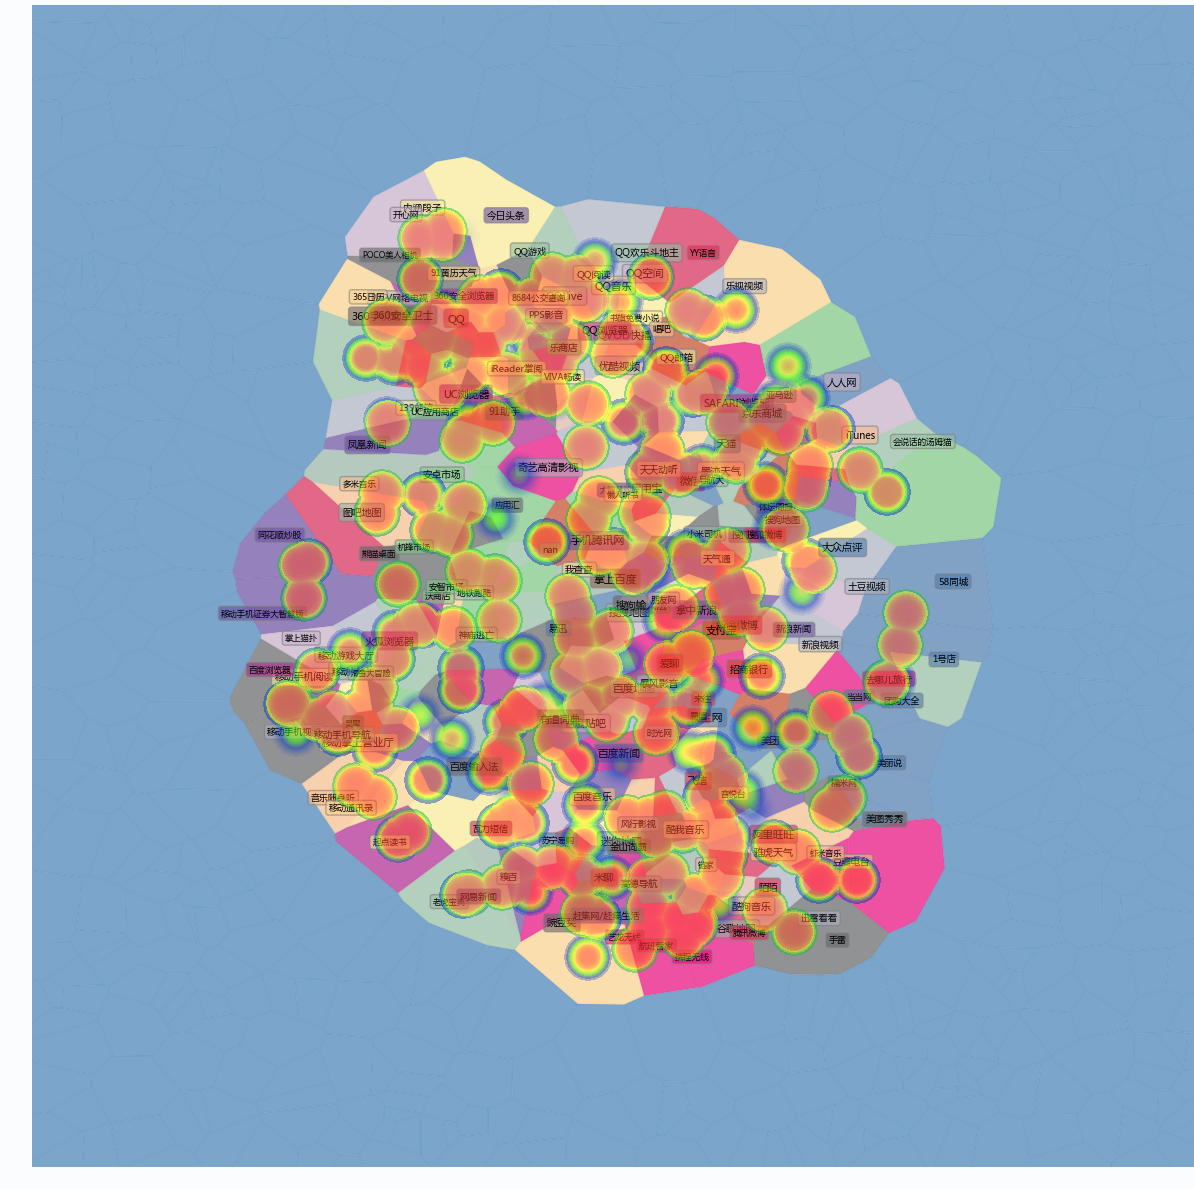

In [144]:
#points=[[750, 750],[750, 750],[750, 750],[750, 750]]
point_diameter=50
point_strength=0.1
opacity=0.5
bookmap = Image.open('bjmobile_good_map.png')
#bookmap = bookmap.filter(ImageFilter.FIND_EDGES)

im = heatmappy(bookmap,opacity,point_diameter,point_strength,points)
im
#im.show()

In [99]:
from PIL import Image
from heatmappy import Heatmapper

In [100]:
example_img_path = 'tiger.jpg'
example_points = [(100, 20), (120, 25), (200, 50), (60, 300), (170, 250)]

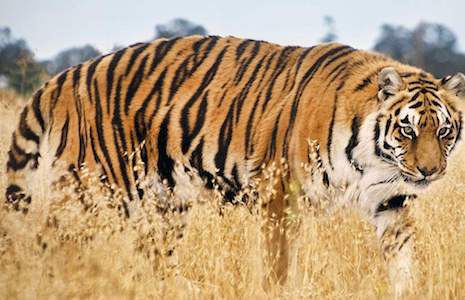

In [102]:
example_img = Image.open(example_img_path)

example_img

# bursts

https://github.com/rpoddighe/pybursts

In [445]:
df14 = pd.read_csv('1441878163.csv', names = ['id', 'num', 'duration', 'time', 'book_id', 'ao'])
df14.head()

,id,num,duration,time,book_id,ao
0,1441878163,1098,0,1.970012e+13,3eb892e52af90242a995e57a,2
1,1441878163,1098,0,1.970012e+13,096fd5ae4431b90d6d85c730,2
2,1441878163,1098,0,1.970012e+13,6d5d5656bceb19e8b9f6ba59,2
3,1441878163,1098,0,1.970012e+13,7d24099c2f60ddccdb38a030,2
4,1441878163,1098,0,1.970012e+13,523c436dc8d376eeaeaa319c,2


In [447]:
from collections import defaultdict

duration_dic  = defaultdict(int)

for i in df14.duration:
    duration_dic[i] += 1 

In [452]:
x, freq = np.array(list(duration_dic.items())).T

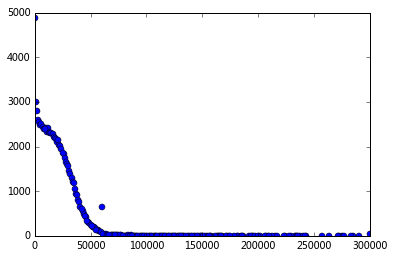

In [455]:
plt.plot(x, freq, 'o')
# plt.xscale('log')
# plt.yscale('log')

In [63]:
import pybursts

offsets = [4, 17, 23, 27, 33, 35, 37, 76, 77, 82, 84, 88, 90, 92]
pybursts.kleinberg(offsets, s=2, gamma=0.1)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

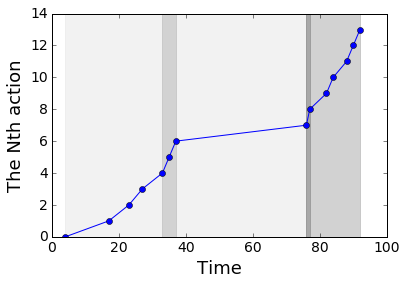

In [17]:
#cp={0:'#BFD7DB',1:'#F4CEA2',2:'#D7D6DB'}
fig = plt.figure(figsize=(6, 4),facecolor='white')
ax = fig.add_subplot(111)
plt.plot(offsets,range(len(offsets)),'bo-')

ax.axvspan(4, 92, alpha=0.5, color='0.9')
ax.axvspan(33, 37, alpha=0.5, color='0.7')
ax.axvspan(76, 92, alpha=0.5, color='0.7')
ax.axvspan(76, 77, alpha=0.5, color='0.5')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time',fontsize=18)
plt.ylabel('The Nth action',fontsize=18)